It may contain environmental **states**, which may not be fully **observable**.

The most common **environment classes**:

|  | Agents | Environment | Observation |
| ---- | ---- | ---- | ---- |
| **Multi-armed bandit** | one | no states | - |
| **Normal-form game** | multiple | no states | - |
| **Markov decision process** | one | multiple states | full |
| **Stochastic/Markov games** | multiple | multiple states | full |
| **Partially observable Markov decision process** | one | multiple states | partial |
| **Partially observable stochastic games** | multiple | multiple states | partial |

In all cases, **reward signals** may be **stochastic** and/or **multi-dimensional**.

Collective or multi-agent reinforcement learning is a natural extension of RL for studying the emerging **collective behavior** of multiple agents in dynamic environments. It enables the formulation of hypotheses about how different **cognitive mechanisms** affect **collective behavior** in **dynamic environments** [@BarfussEtAl2025].

## Multi-agent environments | Games

In all cases, **reward signals** may be **stochastic** and/or **multi-dimensional**.

In [ ]:
class Environment:
    """Abstract environment class."""
    
    def obtain_StateSet(self):
        """Default state set representation `state_s`."""
        return [str(s) for s in range(self.Z)]

    def obtain_ActionSets(self):
        """Default action set representation `action_a`."""
        return [str(a) for a in range(self.M)]
        
    def step(self, 
             jA # joint actions
            ) -> tuple:  # (observations_Oi, rewards_Ri, info)
        """
        Iterate the environment one step forward.
        """
        # choose a next state according to transition tensor T
        tps = self.TransitionTensor[tuple([self.state]+list(jA))].astype(float)
        next_state = np.random.choice(range(len(tps)), p=tps)
    
        # obtain the current rewards
        rewards = self.RewardTensor[tuple([slice(self.N),self.state]
                                          +list(jA)+[next_state])]
    
        # advance the state and collect info
        self.state = next_state
        obs = self.observe()     
    
        # report the true state in the info dict
        info = {'state': self.state}
    
        return obs, rewards.astype(float), info

    def observe(self):
        """Observe the environment."""
        return [self.state for _ in range(self.N)]
        

### Interface


First, we adjust the `interface_run` function to work with the multi-agent environment.

We can make the *columns* of a dataframe adaptive to the number of agents. 

In [ ]:
NrAgents = 2; NrOfTimesteps = 4

def create_dataframe(NrAgents, NrOfTimesteps):
    columns = list(np.array([(f"action{i}", f"observation{i}", f"reward{i}",
                              f"beliefs{i}", f"policy{i}", 
                              f"ChoiceIntensity{i}", f"LearningRate{i}") 
                             for i in range(NrAgents)]).flatten())
    
    return pd.DataFrame(index=range(NrOfTimesteps), columns=columns)

madf = create_dataframe(NrAgents, NrOfTimesteps)
madf.columns

Index(['action0', 'observation0', 'reward0', 'beliefs0', 'policy0',
       'ChoiceIntensity0', 'LearningRate0', 'action1', 'observation1',
       'reward1', 'beliefs1', 'policy1', 'ChoiceIntensity1', 'LearningRate1'],
      dtype='object')

We also write a function to populate the DataFrame with the values of the learning process.

In [ ]:
def fill_dataframe(actions, next_observations, rewards, agents):
    data = []
    for i in range(len(agents)):
        data += [actions[i], next_observations[i], rewards[i],
                 deepcopy(agents[i].ValueBeliefs_Qoa), 
                 deepcopy(agents[i].obtain_policy_Xoa()),
                 deepcopy(agents[i].ChoiceIntensity), 
                 deepcopy(agents[i].LearningRate)]
    return data

Adjusting the `interface_run` function to work with the multi-agent environment yields a clean and readable implementation.

In [ ]:
def interface_run(agents, env, NrOfTimesteps):
    """Run the multi-agent environment for several time steps."""
    df = create_dataframe(len(agents), NrOfTimesteps)

    observations = env.observe()
    
    for t in range(NrOfTimesteps):
                
        actions = [agent.act(observations[i])
            for i, agent in enumerate(agents)]

        next_observations, rewards, info = env.step(actions)

        for i, agent in enumerate(agents):
            agent.update(observations[i], actions[i], rewards[i], next_observations[i])
    
        df.loc[t] = fill_dataframe(actions, next_observations, rewards, agents)

        observations = next_observations
    
    return df

Testing whether it works in our previous environment, the risk-reward dilemma looks promising.

In [ ]:
learner = Learner(ValueBeliefs_Qoa = 8*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 60.0)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

# Note: we need to pass the learner as a list of agents
df = interface_run([learner], env, 4) 

In [ ]:
df

,action0,observation0,reward0,beliefs0,policy0,ChoiceIntensity0,LearningRate0
0,1,0,1.0,"[[8.0, 7.93], [8.0, 8.0]]","[[0.9852259683067277, 0.014774031693272396], [...",60.0,0.1
1,0,0,0.8,"[[7.927906923600332, 7.93], [8.0, 8.0]]","[[0.46864505269071266, 0.5313549473092875], [0...",60.0,0.1
2,0,0,0.8,"[[7.8567279493493345, 7.93], [8.0, 8.0]]","[[0.012172569010807209, 0.9878274309891928], [...",60.0,0.1
3,1,0,1.0,"[[7.8567279493493345, 7.86061972818162], [8.0,...","[[0.4418871301229423, 0.5581128698770577], [0....",60.0,0.1


The real test, however, comes with a true multi-agent environment.

### Social dilemmas environment

Let's extend our treatment of reinforcement learning to **multiple agents**. 
From the perspective of each individual agent, other agents make the environment **non-stationary**. This can complicate reinforcement learning significantly.

We here focus on normal-form games and use the generic model of a social dilemma, introduced in Lecture [03.02-StrategicInteractions](03.02-StrategicInteractions.ipynb).

$$
\begin{array}{c|cc}
\text{} & \color{blue}{\mathsf{Abate}} & \color{blue}{\mathsf{Pollute}} \\
\hline
\color{red}{\mathsf{Abate}} & {\color{red}{1}} \ | \ {\color{blue}{1}} & {\color{red}{-1-F}} \ | \ {\color{blue}{+1+G}} \\
\color{red}{\mathsf{Pollute}} & {\color{red}{+1+G}} \ | \ {\color{blue}{-1-F}} & {\color{red}{-1}} \ | \ {\color{blue}{-1}} \\
\end{array}
$$

Depending on whether the greed $G$ and fear $F$ are positive or negative, we can distinguish four types of games @fig-social-dilemma-dimensions.

![Dimensions of a social dilemma with ordinal payoffs and Nash equilibira shown in boxes.](images/03.02-SocialDilemmaDimensions.dio.png){#fig-social-dilemma-dimensions}

In @fig-social-dilemma-dimensions, the payoff values are ordinal, meaning that only their order, $3>2>1>0$, is considered of relevance.

We also implement it as a class using the same interface as before and letting it inherit from our base environment.

In [ ]:
class SocialDilemma(Environment):
    """A simple social dilemma environment."""

    def obtain_StateSet(self):
        return ['.']  # a dummy state

    def obtain_ActionSets(self):
        # abate, pollute for two agents
        return [['a', 'p'], ['a', 'p']]  

Due to the absence of environmental state transitions, the environment consistently exists in a single, effective dummy state. Consequently, the transition tensor is simplified significantly.

In [ ]:
def create_TransitionTensor(self):
    """Create the transition tensor."""
    return np.ones((self.Z, self.M, self.M, self.Z))
    
SocialDilemma.create_TransitionTensor = create_TransitionTensor

The reward tensor is slighlty more complicated. The two defining parameters of the social dilemma environemtn are the greed $G$ and the fear $F$.

In [ ]:
F, G = sp.symbols('F G')

We represent rewards using a five-dimensional tensor with dimensions $N \times Z \times M \times M \times Z$. Here, $N$ denotes the number of agents, $Z=1$ signifies the state count, and $M$ indicates the number of actions. A uni-dimensional state dimension is essential for accommodating multi-state environments.

In [ ]:
R = np.zeros((2,1,2,2,1), dtype=object)

Helper variable for the indices facilitate the construction of the reward tensor.

In [ ]:
a = SocialDilemma().obtain_ActionSets()[0].index('a')
p = SocialDilemma().obtain_ActionSets()[0].index('p')
a,p

(0, 1)

Mutual abatement yields a reward of one for both agents.


In [ ]:
R[0, 0, a, a, 0] = R[1, 0, a, a, 0] = 1

Mutual pollution yields a reward of minus one for both agents.


In [ ]:
R[0, 0, p, p, 0] = R[1, 0, p, p, 0] = -1

Pollution by one agent and abatement by the other agent yields a reward of one plus the greed for the polluting agent and minus the fear for the abating agent.

In [ ]:
R[0, 0, p, a, 0] = R[1, 0, a, p, 0] = 1 + G
R[0, 0, a, p, 0] = R[1, 0, p, a, 0] = -1 - F

In sum, the reward tensor for agent zero reads,

In [ ]:
sp.Array(R[0,0,:,:,0])

[[1, -F - 1], [G + 1, -1]]

and for agent one,

In [ ]:
sp.Array(R[1,0,:,:,0])

[[1, G + 1], [-F - 1, -1]]

In [ ]:
def create_RewardTensor(self):
    """Create the reward tensor."""
    return substitute_in_array(
        R, {F: self.Fear, G: self.Greed}).astype(float)
    
SocialDilemma.create_RewardTensor = create_RewardTensor

The two defining parameters of the social dilemma are the greed $G$ and the fear $F$.

In [ ]:
def __init__(self, Greed, Fear):
    self.N = 2; self.M = 2; self.Z = 1
    
    self.Greed = Greed
    self.Fear = Fear
    
    self.StateSet = self.obtain_StateSet()
    self.ActionSets = self.obtain_ActionSets()
    self.TransitionTensor = self.create_TransitionTensor()
    self.RewardTensor = self.create_RewardTensor()
    
    self.state = 0
SocialDilemma.__init__ = __init__

### Testing the implementation:

In [ ]:
env = SocialDilemma(Fear=0.65, Greed=0.75)

Mutual cooperation by two abating agents:

In [ ]:
env.step([a,a])

([0, 0], array([1., 1.]), {'state': 0})

Mutual defection by two polluting agents:

In [ ]:
env.step([p,p])

([0, 0], array([-1., -1.]), {'state': 0})

Different actions:

In [ ]:
env.step([a,p])

([0, 0], array([-1.65,  1.75]), {'state': 0})

In [ ]:
env.step([p,a])

([0, 0], array([ 1.75, -1.65]), {'state': 0})

Testing whether the implementation works,

In [ ]:
learner1 = Learner(ValueBeliefs_Qoa = 8*np.ones((1,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 60.0)
learner2 = deepcopy(learner1)

env = SocialDilemma(Fear=1, Greed=2)

df = interface_run([learner1, learner2], env, 4) 
df

,action0,observation0,reward0,beliefs0,policy0,ChoiceIntensity0,LearningRate0,action1,observation1,reward1,beliefs1,policy1,ChoiceIntensity1,LearningRate1
0,1,0,3.0,"[[8.0, 7.95]]","[[0.9525741268224331, 0.047425873177566774]]",60.0,0.1,0,0,-2.0,"[[7.9, 8.0]]","[[0.0024726231566347743, 0.9975273768433652]]",60.0,0.1
1,0,0,-2.0,"[[7.899786583570701, 7.95]]","[[0.0468507276383191, 0.9531492723616809]]",60.0,0.1,1,0,3.0,"[[7.9, 7.94997774639159]]","[[0.047486230263144295, 0.9525137697368558]]",60.0,0.1
2,1,0,-1.0,"[[7.899786583570701, 7.860288271841277]]","[[0.9145029408174301, 0.08549705918256983]]",60.0,0.1,1,0,-1.0,"[[7.9, 7.860264375998088]]","[[0.9156096786764698, 0.08439032132353015]]",60.0,0.1
3,0,0,1.0,"[[7.830484788680395, 7.860288271841277]]","[[0.14329244697889626, 0.8567075530211037]]",60.0,0.1,0,0,1.0,"[[7.830698202813024, 7.860264375998088]]","[[0.14504926660635398, 0.854950733393646]]",60.0,0.1


throws no erros.

### Transient cooperation

In this section, we show that reinforcement learning agents can learn to cooperate in a tragedy social dilemma environment. However, this cooperation is not stable. It is only a transient phenomenon [@GollEtAl2024].

We use a social dilemma with fear $F=1$ and greed $G=2$.

In [ ]:
env = SocialDilemma(Fear=1, Greed=2)

We want to give the agents an inital boost to cooperate or abate. Thus, we give them an inital higher value belief for abate than pollute.

In [ ]:
learner1 = Learner(ValueBeliefs_Qoa = np.array([[0.5, -0.5]]), 
                   DiscountFactor = 0.9,
                   LearningRate = 0.01,
                   ChoiceIntensity = 5.0)

We assume the second agent to be identical to the first one.

In [ ]:
learner2 = deepcopy(learner1)

In [ ]:
np.random.seed(42)
df = interface_run([learner1, learner2], env, 20000) 

In [ ]:
def plot_TwoAgentBeliefsPolicies(df):
    beliefs0_Qtoa = np.array(df.beliefs0.values.tolist())
    policy0_Xtoa = np.array(df.policy0.values.tolist())
    beliefs1_Qtoa = np.array(df.beliefs1.values.tolist())
    policy1_Xtoa = np.array(df.policy1.values.tolist())
    
    fig = plt.figure(figsize=(14,6))
    
    ax0 = fig.add_subplot(311); ax0.set_ylabel('Value beliefs');
    ax0.plot(beliefs0_Qtoa[:,0,a], label='Q1(a)', color='blue',lw=2)
    ax0.plot(beliefs0_Qtoa[:,0,p], label='Q1(p)', color='red', lw=2)
    ax0.plot(beliefs1_Qtoa[:,0,a], label='Q2(a)', color='darkblue', ls='--')
    ax0.plot(beliefs1_Qtoa[:,0,p], label='Q2(p)', color='darkred', ls='--')
    ax0.legend(loc='center right'); ax0.set_xlim(-10, len(df)*1.1)
    
    ax1 = fig.add_subplot(312, sharex=ax0); ax1.set_ylabel('Policy')
    ax1.plot(policy0_Xtoa[:,0,a], label='X1(a)', color='blue', lw=2)
    ax1.plot(policy0_Xtoa[:,0,p], label='X1(p)', color='red', lw=2)
    ax1.plot(policy1_Xtoa[:,0,a], label='X2(a)', color='darkblue', ls='--')
    ax1.plot(policy1_Xtoa[:,0,p], label='X2(p)', color='darkred', ls='--')
    ax1.set_xlabel('Time steps'); ax1.legend(loc='center right')


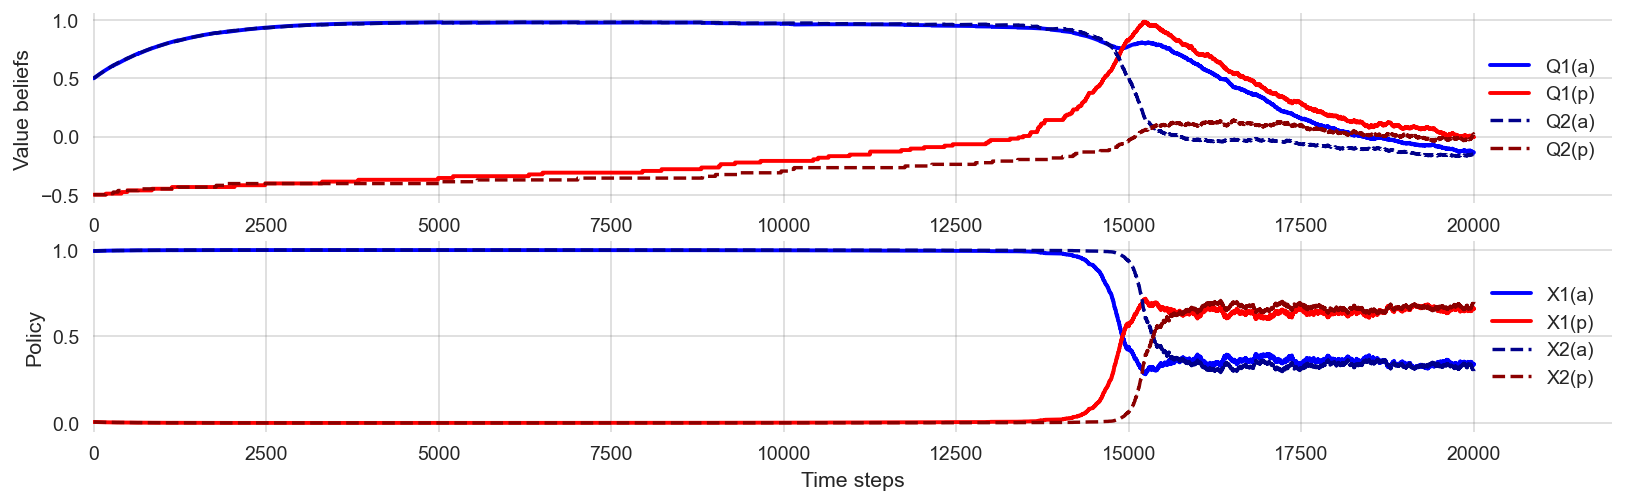

In [ ]:
#| fig-cap: "Transient cooperation in a tragedy social dilemma."
plot_TwoAgentBeliefsPolicies(df)

A propensity for cooperation coupled with excessive exploitation initially leads to transient cooperation within the stochastic learning dynamics. If one is unaware of this phenomenon, it may seem that the issue of cooperation in social dilemmas is resolved. However, as learning continues, this cooperation phase diminishes, resulting in increased defection (pollution) over cooperation (abate). During this phase, agents explore excessively, necessitating a higher choice intensity to establish more deterministic policies that align with the Nash equilibrium of full defection.

The timeing of when the breakdown of cooperation happens is stochastic. **Re-run the simulation above with differnt random seeds to see that this is true**. Beaware, that you must re-initalize the learners to begin from scratch.

### Challenges

- The **learning is inefficient**. The agents require many interactions with the environment to learn what to do as they do not learn any model of the environment. This is a cognitive wasteful process.
- Dealing with **rare states/events** is **challenging** when learning from only experience. Even more sample interactions are required to have enough experience of the raw events.
- The **stochasticity and hyperparameter tuning** make it a **cumbersome modeling tool**. Both elements are invaluable for RL as an optimization method. For RL as a model of the cognitive processes underpinning human behavior, stochasticity and hyperparameter tuning complicate the modeling process considerably. They make studying the learning dynamics more difficult than necessary.

Up next: Deterministic approximations